In [477]:
import json
import numpy as np
import pandas as pnd
import datetime
import h5py
import os 
import matplotlib
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show, output_notebook


def removeOutliers(data, minDelta=0,windowHalfSize=5):#Window len=windowHalfSize*2+1
    def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
        nrows = ((a.size-L)//S)+1
        n = a.strides[0]
        return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))
    res = np.array(data)
    WindowLen = 2*windowHalfSize +1
    if res.shape[0]>WindowLen:
        pp = np.nanpercentile( strided_app(res,WindowLen,1), [25,75], axis=-1)
        vals= res[windowHalfSize:-windowHalfSize]
        nanmask = np.logical_or(np.isnan(vals),np.isnan(pp[0]))
        nanmask = ~np.logical_or(nanmask,np.isnan(pp[0]))
    
        IRQ = 1.5*(pp[1] - pp[0])
        IRQ=np.clip(IRQ, minDelta, None)
        pp[0] -= IRQ;
        pp[1] += IRQ;
        mask = np.zeros_like(vals,dtype=np.bool)
        vals = vals[nanmask]
        pp=pp[:,nanmask]
        mask[nanmask]=np.logical_or(vals<pp[0],vals>pp[1])
        (res[windowHalfSize:-windowHalfSize])[mask] = np.nan
    return res

def FillNan_LinInterp(data):
    res = np.array(data);
    NanMask = np.isnan(data)
    notNan = ~NanMask
    x = np.arange(data.shape[0])
    res[NanMask] = np.interp(x[NanMask],x[notNan],data[notNan])
    return res

def PrepareBeautifulData(data):
    return FillNan_LinInterp(removeOutliers(data))

def removeOutliersNaiv(data, minDelta=0,bufferHalfSize=5):
    res = np.array(data)
    for i in range(bufferHalfSize,res.shape[0]-bufferHalfSize):
        r = res[i]
        if np.isnan(r):
            continue
        xx= data[i-bufferHalfSize:i+bufferHalfSize+1]
        m=~np.isnan(xx)
        if np.sum(m)>3:
            P = np.percentile(xx[m],[25,75])
            IRQ=np.max((minDelta,1.5*(P[1]-P[0])))
            if r<P[0]-IRQ or r>P[1]+IRQ:
                res[i] = np.nan
    return res

In [478]:
exp_files=[r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\juris test 1.h5", #0
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\juris test 2.h5",
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\juris test 4.h5",  #2
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\PAIC test.h5",
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\PAIC-last test.h5", #4
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\PAIC-repeated test.h5",
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\Sep-16-2019.h5", #6
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\Sep-16-2019-1.h5",
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\temp.h5", #8
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\Test_0920_1.h5",
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\Test_0920_2.h5", #10
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\Test_0920_3.h5",
r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\Test_0920_4.h5" #12
]

# Read result file and prepare program data

In [479]:
FileName = r"c:\Calculations\Tribometer_SVN\TribometerResults\ExperimentalData\PAIC test.h5"
FileName = exp_files[9]

In [480]:
f = h5py.File(FileName, 'r', libver='latest')
calibrFr= f["calibrFr"]
calibrLoad= f["calibrLoad"]
data = f["data"][:,:]
setting=f["data"].attrs["allsettings"].decode('utf-8')
setting=json.loads(setting)
col_names=f["data"].attrs['columns'].decode('utf-8')
StartTime=f["data"].attrs['StartTime'].decode('ascii')
StartTime = datetime.datetime.strptime(StartTime,'%Y-%m-%d %H:%M:%S.%f')
user = f["data"].attrs['user'].decode('utf-8')
bearing =f["data"].attrs['bearing'].decode('utf-8')
stopreason=f["stop_reason"][0].decode('utf-8')
f.close()

pr = setting["program"]
program = pnd.DataFrame(data= np.empty(shape=(2*len(pr),5),dtype=np.float),
                        columns=['time','load','RPM','Fmax', 'Tmax'])
t0=0.0
for i,p in enumerate(pr):
    l= np.array([t0,p['load'],p['RPM'],p['Fmax'], p['Tmax']])
    program.iloc[2*i] = l
    t0+=p['duration']*60
    l[0] = t0-1E-4
    program.iloc[2*i+1] = l
    
(os.path.basename(FileName),
 stopreason,
 ("manual_mode" if setting["manual_mode"] else program),
 col_names,
 StartTime)

('Test_0920_1.h5',
 'Successfully finished',
         time    load    RPM   Fmax   Tmax
 0     0.0000   600.0  200.0  100.0  100.0
 1    59.9999   600.0  200.0  100.0  100.0
 2    60.0000   600.0  400.0  100.0  100.0
 3   119.9999   600.0  400.0  100.0  100.0
 4   120.0000   800.0  400.0  100.0  100.0
 5   179.9999   800.0  400.0  100.0  100.0
 6   180.0000   800.0  600.0  100.0  100.0
 7   239.9999   800.0  600.0  100.0  100.0
 8   240.0000   800.0  800.0  100.0  100.0
 9   299.9999   800.0  800.0  100.0  100.0
 10  300.0000  1000.0  800.0  100.0  100.0
 11  359.9999  1000.0  800.0  100.0  100.0,
 'time[s], Load[N], FrictionForce[N], RPM[rotation per minute], temperature[°C]',
 datetime.datetime(2019, 9, 20, 8, 52, 12, 777912))

# Draw results

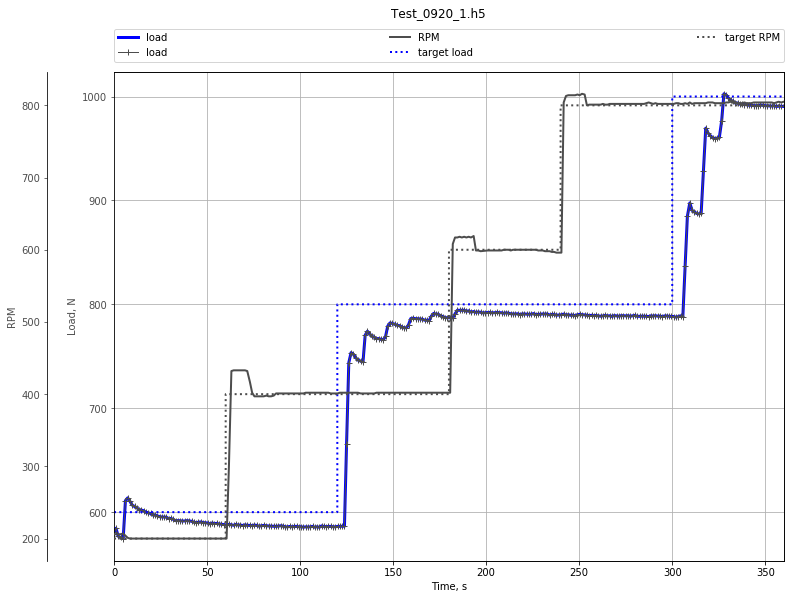

In [482]:
drawFr=False
drawT=False
drawMin=False
imageFileName = r'c:\temp\results.'+os.path.basename(FileName)+'.png'
fig, axLoad = plt.subplots(figsize=(12, 9))
fig.suptitle(os.path.basename(FileName))#, fontsize=14, fontweight='bold')
if drawFr: axFr = axLoad.twinx()
if drawT: axT = axLoad.twinx()
axRPM = axLoad.twinx()

#def timeTicks(x, pos):                                                                                                                                                                                                                                                         
#    d = datetime.timedelta(seconds=x)                                                                                                                                                                                                                                          
#    return str(d)                                                                                                                                                                                                                                                              
#formatter = matplotlib.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
#axLoad.xaxis.set_major_formatter(formatter)
if drawFr:axT.spines["right"].set_position(("axes", 1.1))
axRPM.spines["left"].set_position(("axes", -0.1))
axRPM.yaxis.set_label_position('left')
axRPM.yaxis.set_ticks_position('left')

axRPM.spines["left"].set_visible(True)
if drawMin:
    axLoad.set_xlabel('Time, minutes')
else:
    axLoad.set_xlabel('Time, s')
axLoad.set_ylabel('Load, N')
axRPM.set_ylabel("RPM")
if drawFr:axFr.set_ylabel("Friction force, N")
if drawT:
    axT.set_ylabel("Temperature, °C")
    #axT.set_ylim(20, 25)

lines = []
t = data[:,0]
if drawMin: t=t/60
    
axLoad.set_xlim(0, t[-1])
#axLoad.set_ylim(np.min(data[:,1]),np.max(data[:,1]))
#axRPM.set_ylim(np.min(data[:,3]),np.max(data[:,3])
l1, = axLoad.plot(t,PrepareBeautifulData(data[:,1]),"b-",label="load",lw=3)
lines.append(l1)
l1, = axLoad.plot(t,PrepareBeautifulData(data[:,1]),"0.3",label="load",lw=1,marker="+")
lines.append(l1)
if drawFr:
    l2, = axFr.plot(t,PrepareBeautifulData(data[:,2]),"g-",label="fliction")
    lines.append(l2)
if drawT:
    l3, = axT.plot(t,PrepareBeautifulData(data[:,4]),"r-",label="temperature")
    lines.append(l3)
l4, = axRPM.plot(t,PrepareBeautifulData(data[:,3]),"0.3",label="RPM",lw=2)
lines.append(l4)

if not setting["manual_mode"]:
    t = program["time"]
    if drawMin: t=t/60
    l5, = axLoad.plot(t,PrepareBeautifulData(program["load"]),"b-",label="target load",lw=2,ls=":")
    lines.append(l5)
    l6, = axRPM.plot(t,PrepareBeautifulData(program["RPM"]),"0.3",label="target RPM",lw=2,ls=":")
    lines.append(l6)

axLoad.yaxis.label.set_color(l1.get_color())
axFr.yaxis.label.set_color(l2.get_color())
axT.yaxis.label.set_color(l3.get_color())
axRPM.yaxis.label.set_color(l4.get_color())

axLoad.tick_params(axis='y', colors=l1.get_color())
axFr.tick_params(axis='y', colors=l2.get_color())
axT.tick_params(axis='y', colors=l3.get_color())
axRPM.tick_params(axis='y', colors=l4.get_color())

axLoad.legend(lines, [l.get_label() for l in lines],bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
axLoad.grid()
plt.savefig(imageFileName,dpi=300,bbox_inches='tight')
plt.show()

# test algorithm removeOutliers

In [472]:
time= data[:,0]
load = data[:,1]
rpm = data[:,3]

Error count [in%]

In [473]:
np.sum(np.isnan(data),axis=0)/data.shape[0]*100

array([0.        , 1.71232877, 3.42465753, 2.73972603, 1.71232877])

In [474]:
avgLoad=np.empty_like(load);avgLoad.fill(np.nan)
avgLoad1=np.empty_like(load);avgLoad1.fill(np.nan)
sigma = np.empty_like(load);sigma.fill(np.nan)
ph = np.empty_like(load);ph.fill(np.nan)
pl = np.empty_like(load);pl.fill(np.nan)
filtredLoad = np.array(load)
for i in range(10,data.shape[0]+1):
    xx= filtredLoad[i-10:i]
    x1= load[i-10:i]
    m = ~np.isnan(x1)
    #sigma[i-1]=np.std(x1[m])
    #sigma[i-1]=np.max((15,2.0*sigma[i-1]))
    #avgLoad[i-1] = np.nanmean(x1)
    avgLoad[i-1] = np.nanmedian(x1)
    #sigma[i-1] = 40
    #ph[i-1] = avgLoad[i-1]+sigma[i-1]
    #pl[i-1] = avgLoad[i-1]-sigma[i-1]
    P = np.nanpercentile(x1,[25,50,75])
    IRQ=np.max((0,5.0*(P[2]-P[1])))
    ph[i-1] = P[2]+IRQ
    pl[i-1] = P[0]-IRQ    
    if np.isnan(x1[-1]) or x1[-1]<pl[i-1] or x1[-1]>ph[i-1]:
        filtredLoad[i-1]=np.nan
    #if np.sum(m)>3:
    #    P = np.nanpercentile(x1,[25,50,75])
    #    IRQ=np.max((0,1.5*(P[2]-P[1])))
    #    ph[i-1] = P[2]+IRQ
    #    pl[i-1] = P[0]-IRQ
    #    if x1[-1]<pl[i-1] or x1[-1]>ph[i-1]:
    #        filtredLoad[i-1]=np.nan
    #    sigma[i-1] = np.max((0,2*1.5*IRQ))
    #    if np.abs(x1[-1]-P[1])>sigma[i-1]:
    #        filtredLoad[i-1]=np.nan
        #mmm =np.abs(avgLoad[i-1]-x1)>sigma[i-1]
        #idx = np.where(mm)[0]+i-10    
        #if mmm[-1]:filtredLoad[i-1]=np.nan
        #filtredLoad[idx] = np.nan
        #xx= filtredLoad[i-10:i]
        #avgLoad1[i-1] = np.nanmean(xx)
        #sigma[i-1]=np.max((15,np.std(xx[m])))    
        #if True and m[-1] and np.abs(avgLoad[i-1]-x1[-1])>1.0*sigma[i-1]:
        #    filtredLoad[i-1] = np.nan
        #    #avgLoad[i-1] = np.nanmean(xx[:-1])
        #    m[-1] = False
        #    #sigma[i-1]=np.std(xx[m])
            
    #prevAvg = avgLoad[i-2]
    #prevS=sigma[i-2]        
    #if False and  not np.isnan(prevAvg) and not np.isnan(prevS) and m[-1]:
    #    dev = (prevAvg - xx)**2
    #    res = np.array(dev)
    #    if prevS<0.1:prevS = 0.1
    #    s2 = prevS*prevS
    #    res= 3*dev/s2
    #    res[m] = np.where(res[m]>10,10,res[m])
    #    w = np.exp(-res)
    #    w/=np.sum(w)
    #    if not np.all(np.isnan(w)):
    #        avgLoad[i-1] = np.sum(xx*w)
    #       sigma[i-1]=np.nansum((w*(xx-avgLoad[i-1])**2))

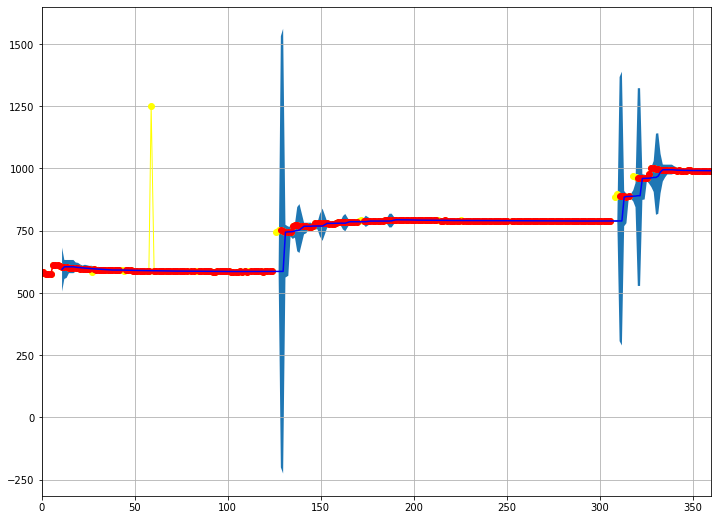

In [475]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(time,load,color="yellow",marker="o",lw=1)
ax.plot(time,filtredLoad,color="red",marker="o")

#ax.plot(time[:-5],avgLoad1[5:],color="blue")
ax.plot(time,avgLoad,color="blue")
#ax.plot(data[:,0],sigma[:],color="yellow")
#ax.plot(program["time"],program["load"],color="0.4")
#ax.fill_between(time[:-5],avgLoad[5:]+sigma[5:], avgLoad[5:]-sigma[5:])
#ax.fill_between(time,avgLoad+sigma, avgLoad-sigma)
ax.fill_between(time,ph, pl)
ax.set_xlim(0,np.max(time))
ax.grid()
plt.show()

In [476]:
output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,box_zoom,reset,save"#,tap,save,box_select,poly_select,lasso_select"
p = figure(tools=TOOLS)
p.square(time,load,line_color="orange",legend="load",color="orange")
p.circle(time,filtredLoad,line_color="red",color="red",legend="load_filtered",line_width=2)

p.line(time,avgLoad,line_color="blue",legend="avgLoad")
p.line(time,ph,line_color="green",legend="high")
p.line(time, pl,line_color="green",legend="low")

show(p)

Loading BokehJS ...